# <font color=green>Final Project - Bagdonas and Manion
    MIS 3080 - Section 001

In [58]:
#Several Traditional SKLearn Regression models with all data

### Import Needed Modules

In [59]:
#general libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

#scikit learn imports
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn import set_config

### Function Definitions

In [60]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file,sourcePath,compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [61]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

### Source Data

In [62]:
#define directory
DOWNLOAD_DIR = "C:/Users/mtman/Desktop/Junior Spring/MIS 3080"

#create the pickle file
pickleFile = open(DOWNLOAD_DIR + "/FinalData.pk1","rb")

#X_instance = pickle.load(pickleFile)
df = pickle.load(pickleFile)

pickleFile.close()

In [63]:
## DATA PREP

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['YldToMtyAsk']), 
    df.YldToMtyAsk, 
    test_size=.2, 
    random_state=32
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3773, 17), (3773,), (944, 17), (944,))

In [65]:
#Pipeline
cat_attribs = ["BBG_Composite", "MtyType", "Currency"]

ord_attribs = ['ESGrating', "FitchRating", "MoodyRtg", "SP_Rating"]

esg_ord = ['N.S.', 'CCC', 'B', 'BB', 'BBB', 'A', 'AA', 'AAA']

fitch_ord = ['Missing', 'WD', 'NR', 'C', 'CC', 'CCC', 'B-', 'B', 'B+',
            'BB-', 'BB', 'BB+', 'BBB-', 'BBB','BBB+','A-','A','A+',
            'AA-','AA','AA+','AAA-','AAA','AAA+']

moody_ord = ['Missing', 'WR', 'NR', 'C', 'Ca','Caa3','Caa2','Caa1',
             'B3','B2','B1','Ba3','Ba2','Ba1','Baa3','Baa2','Baa1',
             'A3','A2','A1','Aa3','Aa2','Aa1','Aaa']

sp_ord = ['Missing', 'NR', 'D', 'CCC-', 'CCC', 'CCC+','B-', 'B', 'B+', 
          'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+', 'AA-', 'AA', 'AAA']

ord_mappings = [esg_ord] + [fitch_ord] + [moody_ord] + [sp_ord]

#set the numerical attributes
num_attribs = list( X_train.drop(columns=cat_attribs+ord_attribs,axis=1) )


#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled using Standard Scaler (works better for traditional SKLearn models)
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), 
 ('std_scaler', StandardScaler()),   
])

ord_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('ord', OrdinalEncoder(categories=ord_mappings))
])
#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('ord', ord_pipeline, ord_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs)    
])

In [66]:
#create an array of prepared data based on the training data set and the Pipeline process defined above
X_train = full_pipeline.fit_transform( X_train)
X_test = full_pipeline.transform( X_test )

X_train.shape, X_test.shape

((3773, 72), (944, 72))

In [67]:
#predcition is based on mean value
baseline_prediction = y_test.mean()

#populate an array with the baseline prediction value
predictions = np.full(shape=y_test.shape[0], fill_value = baseline_prediction)

#unscale predicted values
actual= y_test

#calculate the root mean square error between the prediction and the actual
naive = mean_squared_error(predictions, actual, squared=False)
print( 'Naive ERROR: {:,.2f}'.format(naive) )

Naive ERROR: 7.38


### Linear Regression

In [68]:
#create a linear regression model
lin_reg=LinearRegression()

#fit the model to the training data set
lin_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = lin_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 6.0028


In [69]:
# cross validation 

#run cross validation
scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.4f}".format( -scores.mean() ) )

RMSE: 11.4953


In [70]:
#the mean value is being heavily influenced by the one outlier score... not a great model
scores

array([ -5.68259403, -14.37699737,  -4.80930078,  -6.56105676,
       -52.51230906,  -6.65061392,  -5.61685773,  -8.10740917,
        -4.8214267 ,  -5.8145764 ])

In [71]:
#use the linear regression model and evaluate the test data set
predictions = lin_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 4.9986


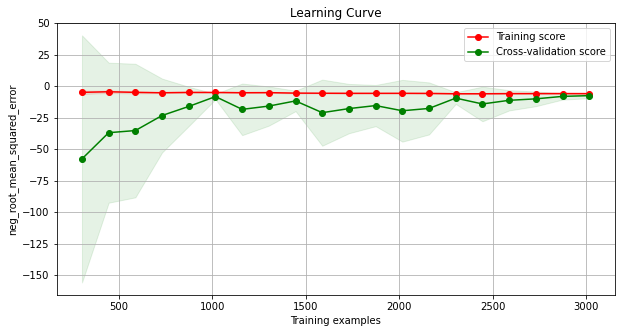

In [72]:
plot_learning_curve(lin_reg, X_train, y_train)

In [73]:
#print using format
for x in range(0,3):
    print( "Prediction {:10,.2f}  ---  Actual {:10,.2f}".format( float(predictions[x:x+1]), float(y_test[x:x+1]) ) )

Prediction       6.76  ---  Actual       4.95
Prediction       7.17  ---  Actual       2.97
Prediction      18.89  ---  Actual       4.45


### Ridge Regression

In [74]:
#create a Ridge Regression model (adds in regularization)
ridge_reg=Ridge(alpha=1, solver='auto')

#fit the model to the training data set
ridge_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = ridge_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 6.0183


In [75]:
#run cross validation
scores = cross_val_score(ridge_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.4f}".format( -scores.mean() ) )

RMSE: 7.0230


In [76]:
#use the ridge regression model and evaluate the test data set
predictions = ridge_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 4.9512


In [77]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    # try all solvers available to Ridge Regression and a few values for alpha
    {'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'saga'],
     'alpha': [1, 2, 5, 10]}
]

# train across 10 folds, that's a total of (4*6)*10=240 rounds of training 
grid_search = GridSearchCV(Ridge(), param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid=[{'alpha': [1, 2, 5, 10],
                          'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                     'sparse_cg', 'saga']}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [78]:
#print the RMSE results from the CV and the paramaters used during each run 
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: {:,.4f} - {}".format( -mean_score, params) )

RMSE: 7.0230 - {'alpha': 1, 'solver': 'auto'}
RMSE: 7.0230 - {'alpha': 1, 'solver': 'svd'}
RMSE: 7.0230 - {'alpha': 1, 'solver': 'cholesky'}
RMSE: 6.9586 - {'alpha': 1, 'solver': 'lsqr'}
RMSE: 6.8355 - {'alpha': 1, 'solver': 'sparse_cg'}
RMSE: 6.9183 - {'alpha': 1, 'solver': 'saga'}
RMSE: 6.8881 - {'alpha': 2, 'solver': 'auto'}
RMSE: 6.8881 - {'alpha': 2, 'solver': 'svd'}
RMSE: 6.8881 - {'alpha': 2, 'solver': 'cholesky'}
RMSE: 6.9472 - {'alpha': 2, 'solver': 'lsqr'}
RMSE: 6.8435 - {'alpha': 2, 'solver': 'sparse_cg'}
RMSE: 6.9247 - {'alpha': 2, 'solver': 'saga'}
RMSE: 6.8861 - {'alpha': 5, 'solver': 'auto'}
RMSE: 6.8861 - {'alpha': 5, 'solver': 'svd'}
RMSE: 6.8861 - {'alpha': 5, 'solver': 'cholesky'}
RMSE: 6.9846 - {'alpha': 5, 'solver': 'lsqr'}
RMSE: 6.8862 - {'alpha': 5, 'solver': 'sparse_cg'}
RMSE: 6.9423 - {'alpha': 5, 'solver': 'saga'}
RMSE: 6.9282 - {'alpha': 10, 'solver': 'auto'}
RMSE: 6.9282 - {'alpha': 10, 'solver': 'svd'}
RMSE: 6.9282 - {'alpha': 10, 'solver': 'cholesky'}
RMSE

In [79]:
#display the best soluiton
grid_search.best_params_

{'alpha': 1, 'solver': 'sparse_cg'}

In [80]:
#use the parameters found above to create the model
model = Ridge(**grid_search.best_params_)

#fit the model to the training data set
model.fit(X_train, y_train)

Ridge(alpha=1, solver='sparse_cg')

In [81]:
#use the best ridge regression model and evaluate the test data set
predictions = model.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test, predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 4.9616


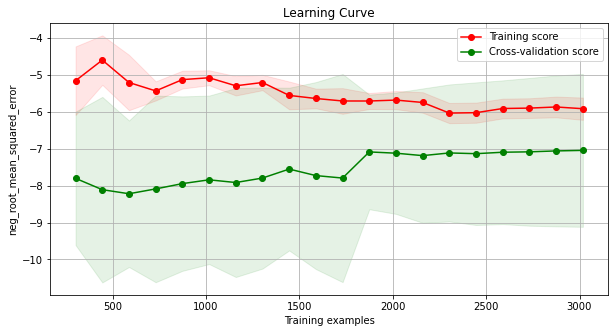

In [82]:
#plotting learning curve
plot_learning_curve(model, X_train, y_train)

In [83]:
#print using format
for x in range(0,3):
    print( "Prediction {:10,.2f}  ---  Actual {:10,.2f}".format( float(predictions[x:x+1]), float(y_test[x:x+1]) ) )

Prediction       7.41  ---  Actual       4.95
Prediction       7.24  ---  Actual       2.97
Prediction      19.16  ---  Actual       4.45


### SGD Regression

In [84]:
#create a Stocahstic Gradiant Descent Regressor object
sgd_reg = SGDRegressor(max_iter=1000, tol=.01, penalty="l2", eta0=.001)

#fit the model to the training data
sgd_reg.fit(X_train, y_train)

#calcualte the predicted values
predictions = sgd_reg.predict(X_train)

#compare the predicted to the actuals to evaluate the model
rmse = mean_squared_error(y_train,predictions,squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 6.5279


In [85]:
#run cross validation
scores = cross_val_score(sgd_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.4f}".format( -scores.mean() ) )

RMSE: 7.1821


In [86]:
#create a parameter grid that determines the variable hyperparameters
param_grid = [
    {'max_iter': [1000, 10000], 'eta0': [ .001, .01, .1],
     'tol': [.001, .01, .1],'penalty':['None', 'l2']},
  ]

# train across 10 folds, that's a total of (2*3*3*2)*10=360 rounds of training 
grid_search = GridSearchCV(SGDRegressor(), param_grid, cv=10,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SGDRegressor(),
             param_grid=[{'eta0': [0.001, 0.01, 0.1], 'max_iter': [1000, 10000],
                          'penalty': ['None', 'l2'],
                          'tol': [0.001, 0.01, 0.1]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [87]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("RMSE: {:,.4f} - {}".format( -mean_score, params) )

RMSE: 7.1713 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'None', 'tol': 0.001}
RMSE: 7.1816 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'None', 'tol': 0.01}
RMSE: 7.1523 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'None', 'tol': 0.1}
RMSE: 7.1603 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}
RMSE: 7.1738 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.01}
RMSE: 7.1510 - {'eta0': 0.001, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.1}
RMSE: 7.1575 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'None', 'tol': 0.001}
RMSE: 7.1813 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'None', 'tol': 0.01}
RMSE: 7.1418 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'None', 'tol': 0.1}
RMSE: 7.1521 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.001}
RMSE: 7.1731 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.01}
RMSE: 7.1661 - {'eta0': 0.001, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.1}
RMSE: 1,156,058.0479 - {'eta0': 0.

In [88]:
grid_search.best_params_

{'eta0': 0.001, 'max_iter': 10000, 'penalty': 'None', 'tol': 0.1}

In [89]:
sgd_model = SGDRegressor(**grid_search.best_params_)
sgd_model.fit(X_train, y_train)

#calcualte the predicted values
predictions = sgd_model.predict(X_test)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_test, predictions,squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 5.0767


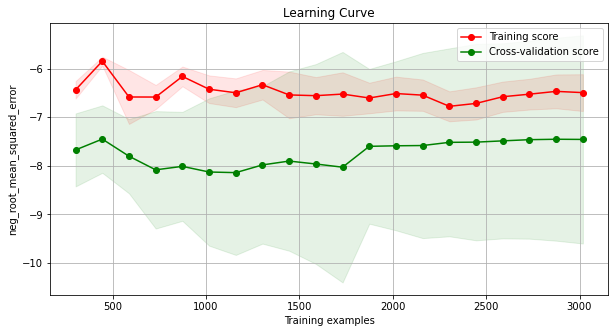

In [90]:
plot_learning_curve(sgd_model, X_train, y_train)

In [91]:
#print using format
for x in range(0,3):
    print( "Prediction {:10,.2f}  ---  Actual {:10,.2f}".format( float(predictions[x:x+1]), float(y_test[x:x+1]) ) )

Prediction       8.82  ---  Actual       4.95
Prediction       6.31  ---  Actual       2.97
Prediction      15.39  ---  Actual       4.45


### Lasso Regression

In [92]:
#create a Lasso Regression model
lasso_reg=Lasso(alpha=1)

#fit the model to the training data set
lasso_reg.fit(X_train, y_train)

#calculated the predicted values for the training data set
predictions = lasso_reg.predict(X_train)

#compare the predicted to the actuals
rmse = mean_squared_error(y_train,predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 6.8401


In [93]:
#run cross validation
scores = cross_val_score(lasso_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.4f}".format( -scores.mean() ) )

RMSE: 7.2908


In [94]:
#use the best Lasso Regression model and evaluate the test data set
predictions = lasso_reg.predict(X_test)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 5.4994


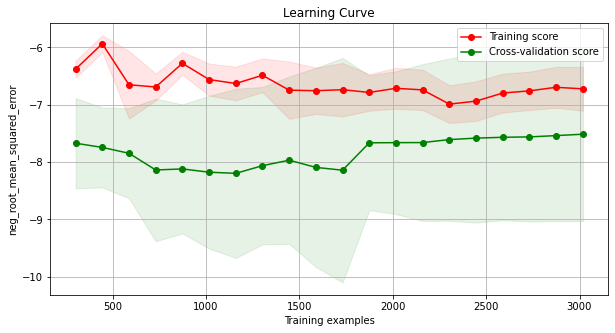

In [95]:
plot_learning_curve(lasso_reg, X_train, y_train)

In [96]:
#print using format
for x in range(0,3):
    print( "Prediction {:10,.2f}  ---  Actual {:10,.2f}".format( float(predictions[x:x+1]), float(y_test[x:x+1]) ) )

Prediction       7.83  ---  Actual       4.95
Prediction       7.33  ---  Actual       2.97
Prediction      15.06  ---  Actual       4.45


### Adding Polynomial Features - Ridge

In [97]:
#review the current shape of our training set
X_train.shape

(3773, 72)

In [98]:
#try making a linear model fit data that is more likely non-linear
DEGREE = 2

#create a polynomial feature with degree based on variable DEGREE
poly_features=PolynomialFeatures(degree=DEGREE)

#transform our X by adding the square of each feature to the training set
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

X_train_poly.shape, X_test_poly.shape

((3773, 2701), (944, 2701))

In [99]:
# use the new, complex data set to train a new model
model_poly = Ridge()

model_poly.fit(X_train_poly, y_train)

Ridge()

In [100]:
#calculate the predicted values
predictions = model_poly.predict(X_train_poly)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_train, predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 3.3250


In [101]:
#calcualte the predicted values
predictions = model_poly.predict(X_test_poly)

#compare the predicted to the actuals
rmse = mean_squared_error( y_test, predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 6.1668


In [102]:
#run cross validation
scores = cross_val_score(model_poly, X_train_poly, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.4f}".format( -scores.mean() ) )

RMSE: 6.1989


In [103]:
#use the best poly ridge Regression model and evaluate the test data set
predictions = model_poly.predict(X_test_poly)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 6.1668


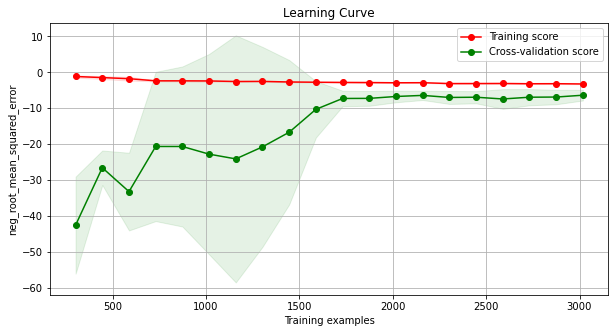

In [104]:
plot_learning_curve(model_poly,X_train_poly,y_train)

In [105]:
#print using format
for x in range(0,3):
    print( "Prediction {:10,.2f}  ---  Actual {:10,.2f}".format( float(predictions[x:x+1]), float(y_test[x:x+1]) ) )

Prediction       6.66  ---  Actual       4.95
Prediction       6.66  ---  Actual       2.97
Prediction      28.27  ---  Actual       4.45


### Polynomial Features - Lasso

In [106]:
# use the new, complex data set to train a new model
lasso_poly = Lasso()

lasso_poly.fit(X_train_poly, y_train)

Lasso()

In [107]:
#calculate the predicted values
predictions = lasso_poly.predict(X_train_poly)

#compare the predicted (housing_predictions) to the actuals(housing_labels)
rmse = mean_squared_error( y_train, predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 5.7910


In [108]:
#calcualte the predicted values
predictions = lasso_poly.predict(X_test_poly)

#compare the predicted to the actuals
rmse = mean_squared_error( y_test, predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 4.2558


In [109]:
#run cross validation
scores = cross_val_score(lasso_poly, X_train_poly, y_train, scoring="neg_root_mean_squared_error", cv=10)

#report the results
print("RMSE: {:,.4f}".format( -scores.mean() ) )

RMSE: 6.6753


In [110]:
#use the best poly lasso Regression model and evaluate the test data set
predictions = lasso_poly.predict(X_test_poly)

#compare the predicted to the actuals
rmse = mean_squared_error(y_test,predictions, squared=False)
print("Prediction Error (RMSE): {:,.4f}".format(rmse))

Prediction Error (RMSE): 4.2558


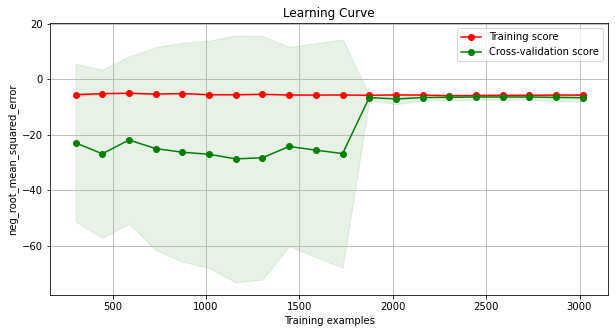

In [111]:
plot_learning_curve(lasso_poly,X_train_poly,y_train)

In [112]:
#print using format
for x in range(0,3):
    print( "Prediction {:10,.2f}  ---  Actual {:10,.2f}".format( float(predictions[x:x+1]), float(y_test[x:x+1]) ) )

Prediction       6.88  ---  Actual       4.95
Prediction       4.96  ---  Actual       2.97
Prediction      14.07  ---  Actual       4.45


In [113]:
set_config(display='diagram')
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['BBPwr', 'EnergyIntensity_Sales',
                                  'WasteGenerated_Sales',
                                  'CO2EmissionsPerSales', 'PercentWmnBoard',
                                  'Cpn', '260D_Volatility', 'Debt_EBITDA',
                                  'FCF_TotDbt', 'Days2Maturity']),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(st...
                                                                              'B3',
                                                                              'B2',
                                                                              'B1',
                                                                              'Ba3',
                                                                              'Ba2',
                                                                              'Ba1',
                                                                              'Baa3',
                                                                              'Baa2',
                                                                              'Baa1',
                                                                              'A3',
                                                                              'A2',
                                                                              'A1',
                                                                              'Aa3',
                                                                              'Aa2',
                                                                              'Aa1',
                                                                              'Aaa'],
                                                                             ['Missing',
                                                                              'NR',
                                                                              'D',
                                                                              'CCC-',
                                                                              'CCC',
                                                                              'CCC+',
                                                                              'B-',
                                                                              'B',
                                                                              'B+',
                                                                              'BB-',
                                                                              'BB',
                                                                              'BB+',
                                                                              'BBB-',
                                                                              'BBB',
                                                                              'BBB+',
                                                                              'A-',
                                                                              'A',
                                                                              'A+',
                                                                              'AA-',
                                                                              'AA',
                                                                              'AAA']]))]),
                   

In [114]:
sgd_model

SGDRegressor(eta0=0.001, max_iter=10000, penalty='None', tol=0.1)